# Introduction

In this notebook, you will create a medical chatbot based on the model **[aaditya/Llama3-OpenBioLLM-8B](https://huggingface.co/aaditya/Llama3-OpenBioLLM-8B)** and also perform LoRA fine-tuning with the dataset `intern_screening_dataset.csv`.

<br>

## Problem Statement

Develop a medical question-answering system utilizing the provided dataset containing medical information. The goal is to create a model that can effectively answer user queries related to medical diseases. You are free to augment the provided dataset with other medical datasets if you feel it is necessary.

<br>

### Constraints

The chatbot must be developed within a 2-day deadline, but future improvements are suggested at the end.

<br>

### Approaches Evaluated

- My initial idea was to use a transformer model with fewer parameters, such as **BERT** or **T5**, but I was concerned about the potential risk of hallucinations in the completions.
- I also considered running a **RAG** on a more powerful model like **GPT** and kept this alternative as a viable option.
- I ultimately decided to go with fine-tuning a **LLM** model to ensure more reliable, domain-specific answers by leveraging a pretrained model with large medical datasets.
- The deadline was an issue, as full fine-tuning could take days. To optimize time, I chose to use **PEFT LoRA**.

<br>

### Notebook Instance

Fine-tuning was performed using an **A100 instance on Google Colab**.



## Requirements


In [ ]:
!pip install pandas
!pip install re
!pip install datasets
!pip install transformers
!pip install torch
!pip install evaluate
!pip install peft
!pip install rouge-score
!pip install matplotlib


## Exploratory Data Analysis

This is an example of an entry in the dataset **intern_screening_dataset.csv**, which contains the columns **question** and **answer**:

<br>

**Question:**
> *What are the symptoms of Diabetes?*

**Answer:**
> Diabetes is often called a "silent" disease because it can cause serious complications even before you have symptoms. Symptoms can also be so mild that you don't notice them. An estimated 8 million people in the United States have type 2 diabetes and don't know it, according to 2012 estimates by the Centers for Disease Control and Prevention (CDC) *(continues…)*.

<br>

I assessed the data integrity by checking for missing columns in the dataset with the script `exploratory_data_analysis.py`:


In [4]:
import pandas as pd

df = pd.read_csv('./data/raw/intern_screening_dataset.csv')

print(f"Total number of entries: {df.shape[0]}")

print(f"Empty questions: {df['question'].isnull().sum()}")
print(f"Empty answers: {df['answer'].isnull().sum()}")

df['question_answer'] = df['question'] + '|' + df['answer']
duplicate_count = df['question_answer'].duplicated().sum()
print(f"Duplicated question-answer pairs: {duplicate_count}")


Total number of entries: 16406
Empty questions: 0
Empty answers: 5
Duplicated question-answer pairs: 52


Before starting the Data Preprocessing, I decided to first perform the Model Selection in order to use the tokenizer tailored for this model and to prepare the columns expected for fine-tuning.

<br>

I researched similar applications and found many Open Source models on Hugging Face:

- [Medical LLM Leaderboard - Fenglin Liu](https://huggingface.co/spaces/fenglinliu/medical_llm_leaderboard)
- [Medical-Llama3-v2 - Ruslanmv](https://huggingface.co/spaces/ruslanmv/Medical-Llama3-v2)
- [Open Medical LLM Leaderboard - Open Life Science AI](https://huggingface.co/spaces/openlifescienceai/open_medical_llm_leaderboard)
- [MedLLMs Practical Guide - AI in Health](https://github.com/AI-in-Health/MedLLMsPracticalGuide?tab=readme-ov-file)
- [Open Medical LLM Leaderboard - Open Life Science AI](https://huggingface.co/spaces/openlifescienceai/open_medical_llm_leaderboard)
- [Hugging Face Blog - Medical LLM Leaderboard](https://huggingface.co/blog/leaderboard-medicalllm)

<br>

I would have liked to evaluate the models more thoroughly, but due to time constraints, I decided to choose the aaditya/Llama3-OpenBioLLM-70B model, which stood out for surpassing GPT and Gemini models in benchmarks:

<br>

![Medical Benchmark Datasets](https://cdn-uploads.huggingface.co/production/uploads/5f3fe13d79c1ba4c353d0c19/oPchsJsEpQoGcGXVbh7YS.png)

Due to being a 70B model, fine-tuning became computationally infeasible, but OpenBioLLM has a smaller 8B variant that fits within the GPU capacity of a Google Colab A100 instance.

<br>

Since OpenBioLLM was trained on a vast corpus of high-quality biomedical data, it meets the task requirement that states "You are free to augment the provided dataset with other medical datasets if you feel it is necessary."

<br>

The model fetch may take up to 10 minutes, so I created the fetch_model.py script to save the model and tokenizer in a local directory:


In [5]:
import transformers
import torch

# Fetch model from Hugging Face
model_id = "aaditya/OpenBioLLM-Llama3-8B"
model = transformers.AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Save model and tokenizer locally
save_directory = "./models"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and Tokenizer saved in: {save_directory}")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model and Tokenizer saved in: ./models


<br>

The script `test_reference_model.py` allows testing the Question Answering task of the **OpenBioLLM-Llama3-8B** model.
The script follows the snippet on the OpenBioLLM-8B page: https://huggingface.co/aaditya/Llama3-OpenBioLLM-8B


In [6]:
import transformers
import torch

model_id = "aaditya/OpenBioLLM-Llama3-8B"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="cuda",
)

# Prompt context and question
messages = [
    {"role": "system", "content": "You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you were developed by Saama AI Labs. who's willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience."},
    {"role": "user", "content": "What are the symptoms of Diabetes?"}
]

# Prompt building
prompt = ""
for message in messages:
    prompt += f"{message['role'].capitalize()}: {message['content']}\n"

outputs = pipeline(
    prompt,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
    eos_token_id=pipeline.tokenizer.eos_token_id,
)

print(outputs[0]["generated_text"][len(prompt):])


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda


OpenBioLLM: Diabetes is a chronic condition that affects the body's ability to regulate blood sugar levels. Common symptoms of diabetes include frequent urination, excessive thirst, unexplained weight loss, increased hunger, fatigue, blurred vision, slow-healing sores or frequent infections, and tingling or numbness in the hands or feet. These symptoms may vary from person to person and can also be associated with other medical conditions. It is important to consult a healthcare professional for an accurate diagnosis and appropriate management of diabetes.


## Data Preprocessing

The `data_preprocessing.py` script performs the following techniques:

- Removed entries with missing answers.
- Removed duplicate question-answer pairs.
- Dropped answers shorter than 100 characters.
- Normalized text (lowercase and stripped spaces).
- Removed special characters.
- Tokenized questions and answers using Hugging Face AutoTokenizer, creating `input_ids` and labels.
- Truncated and padded sequences to a maximum length of 512.
- Computed start and end token positions for answers using `char_to_token`.
- Converted the cleaned DataFrame to a Hugging Face Dataset and saved it.

I encountered some difficulty aligning the columns correctly when preparing the dataset for fine-tuning, particularly ensuring that the columns `input_ids`, `labels`, `start_positions`, and `end_positions` were properly formatted.

<br>

To develop the `get_answer_positions` function, I consulted the following resources:

- [Hugging Face Custom Datasets Guide](https://huggingface.co/transformers/v3.1.0/custom_datasets.html)
- [Hugging Face Documentation on Question Answering](https://huggingface.co/docs/transformers/tasks/question_answering)
- [WandB Article on Extractive Question Answering with Hugging Face](https://wandb.ai/mostafaibrahim17/ml-articles/reports/Extractive-Question-Answering-With-HuggingFace-Using-PyTorch-and-W-B--Vmlldzo0MzMwOTY5)

<br>


In [1]:
import pandas as pd
import re
from datasets import Dataset
from transformers import AutoTokenizer

# Special characters cleaning
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Punctuation
    text = re.sub(r'\d+', '', text)  # Numbers
    return text

# Get start and end positions of the answer
def get_answer_positions(question, answer):
    context = question + " " + answer
    start = context.find(answer)
    end = start + len(answer) - 1

    # Tokenize the context
    tokenized_context = tokenizer(context, truncation=True, padding='max_length', max_length=512)

    start_token_pos = tokenized_context.char_to_token(start)
    end_token_pos = tokenized_context.char_to_token(end)

    # Get last valid token in case of None
    if start_token_pos is None or end_token_pos is None:
        start_token_pos = len(tokenized_context['input_ids']) - 1
        end_token_pos = len(tokenized_context['input_ids']) - 1

    return start_token_pos, end_token_pos


df = pd.read_csv('./data/raw/intern_screening_dataset.csv')

# Removed entries with missing answers
df = df.dropna(subset=['answer'])

# Removed duplicate question-answer pairs
df['question_answer'] = df['question'] + ' | ' + df['answer']
df = df.drop_duplicates(subset='question_answer')
df.drop(columns='question_answer', inplace=True)

# Dropped answers shorter than 100 characters
df = df[df['answer'].str.strip().str.len() > 100]

# Normalized text (lowercase and stripped spaces)
df['question'] = df['question'].str.lower()
df['answer'] = df['answer'].str.lower()

df['question'] = df['question'].str.strip()
df['answer'] = df['answer'].str.strip()

# Removed special characters
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

# Tokenized questions and answers using Hugging Face AutoTokenizer, creating input_ids and labels
model_id = "aaditya/OpenBioLLM-Llama3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_id)

df['input_ids'] = df['question'].apply(lambda x: tokenizer.encode(x, padding='max_length', truncation=True, max_length=512))
df['labels'] = df['answer'].apply(lambda x: tokenizer.encode(x, padding='max_length', truncation=True, max_length=512))

# Computed start and end token positions for answers using char_to_token
df['start_positions'], df['end_positions'] = zip(*df.apply(lambda x: get_answer_positions(x['question'], x['answer']), axis=1))

# Drop as colunas question e answer
df.drop(columns=['question', 'answer'], inplace=True)

# Keeping only necessary columns
df = df.reset_index(drop=True)
df = df[['input_ids', 'labels', 'start_positions', 'end_positions']]

print(df.head(5))

# Converted the cleaned DataFrame to a Hugging Face Dataset and saved it
dataset = Dataset.from_pandas(df)
dataset.save_to_disk('./data/processed/intern_screening_dataset')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                           input_ids  \
0  [12840, 374, 527, 2840, 2933, 82945, 220, 1280...   
1  [12840, 374, 527, 2840, 2933, 82945, 220, 1280...   
2  [12840, 374, 527, 2840, 2933, 82945, 220, 1280...   
3  [14965, 374, 520, 5326, 369, 2840, 2933, 82945...   
4  [5269, 311, 5471, 2840, 2933, 82945, 220, 1280...   

                                              labels  start_positions  \
0  [6200, 2933, 82945, 374, 264, 1912, 315, 19338...                7   
1  [1820, 81209, 32015, 374, 264, 13190, 315, 810...                7   
2  [2569, 4134, 2840, 2933, 82945, 374, 279, 1455...                7   
3  [3852, 606, 649, 2274, 2840, 2933, 82945, 1063...                9   
4  [266, 420, 892, 584, 656, 539, 1440, 1268, 311...                7   

   end_positions  
0            134  
1             26  
2            107  
3            112  
4             97  


Saving the dataset (0/1 shards):   0%|          | 0/16023 [00:00<?, ? examples/s]

<br>

## Model Training

The `fine_tuning.py` script performs PEFT LoRA fine-tuning for the Question Answering task. The training took approximately 2 hours and was conducted with standard hyperparameters:

<br>

I used the following resources as references to develop the fine-tuning LoRA function for the Llama 3-8B model:

- [Fine-tuning Llama 2 models using a single GPU, QLoRA, and AI Notebooks](https://blog.ovhcloud.com/fine-tuning-llama-2-models-using-a-single-gpu-qlora-and-ai-notebooks/)
- [Fine-tuning Llama 2 using LoRA and QLoRA: A Comprehensive Guide](https://medium.com/@harsh.vardhan7695/fine-tuning-llama-2-using-lora-and-qlora-a-comprehensive-guide-fd2260f0aa5f)
- [Fine-tuning Large Language Models: Customize Llama 3-8B for Your Needs](https://medium.com/@miloszivic99/finetuning-large-language-models-customize-llama-3-8b-for-your-needs-bfe0f43cd239)
- [How to Fine-tune Llama 3-1.8B Instruct](https://medium.com/@rschaeffer23/how-to-fine-tune-llama-3-1-8b-instruct-bf0a84af7795)
- [Fine-tuning Llama3 for Q&A Tasks using Unsloth](https://www.kaggle.com/code/lhai0704/fine-tuning-llama3-for-q-a-tasks-using-unsloth)
- [Fine-tuning Llama3 Locally](https://www.datacamp.com/tutorial/llama3-fine-tuning-locally)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.018700,2.919188
2,2.968500,2.902077
3,2.861300,2.797840


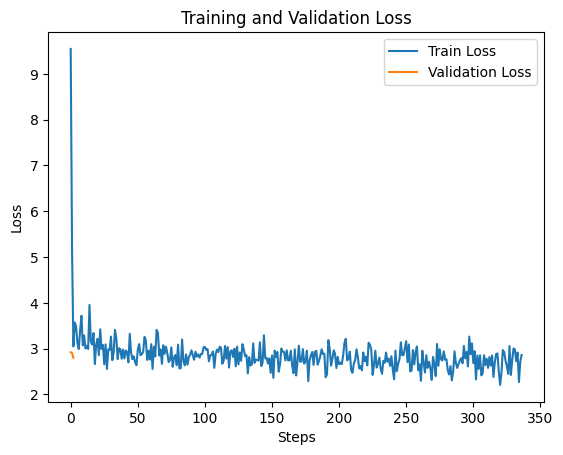

In [1]:
import json
import torch
import matplotlib.pyplot as plt
from datasets import load_from_disk, Dataset
from peft import get_peft_model, LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from evaluate import load as load_metric

# Load preprocessed dataset
tokenized_datasets = load_from_disk('./data/processed')
tokenized_datasets = tokenized_datasets.map(lambda x: {'id': list(range(len(x)))})
train_test_split = tokenized_datasets.train_test_split(test_size=0.3)

# Loading reference model
model_id = "aaditya/OpenBioLLM-Llama3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16)

# GPU selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# LoRA initialization
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    task_type="QUESTION_ANS"
)

peft_model = get_peft_model(model, lora_config)

# Initializing training
training_args = TrainingArguments(
    output_dir="./results_qa",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    save_strategy="epoch",
    fp16=False,
    logging_steps=50,
    logging_first_step=True,
    report_to="tensorboard",
    disable_tqdm=False,
    no_cuda=False,
    remove_unused_columns=False
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_test_split["train"],
    eval_dataset=train_test_split["test"]
)

trainer.train()

# Saving fine-tuned model
peft_model.save_pretrained('./finetune')

# Training and validation loss visualization
training_logs = trainer.state.log_history

train_loss = [log['loss'] for log in training_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]

plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


The fine-tuning is converging, as both the Training Loss and Validation Loss are decreasing with each epoch.  

<br>

It would be beneficial to run for more epochs and perform hyperparameter tuning. However, due to time constraints, I will proceed to the model evaluation stage.


## Model Evaluation

Since the reference model aaditya/Llama3-OpenBioLLM-8B was trained for the LlamaForCausalLM architecture, the most appropriate evaluation metric is ROUGE.

<br>

ROUGE is commonly used for evaluating text generation tasks, where the focus is on comparing the generated text with reference text based on recall, precision, and F1 score.

<br>

The script `model_evaluation.py` calculates the ROUGE for the **aaditya/Llama3-OpenBioLLM-8B** model with and without fine-tuning using the `intern_screening_dataset.csv` dataset:



In [1]:
import transformers
import torch
import pandas as pd
from rouge_score import rouge_scorer

finetuned_model_id = "./finetune"
reference_model_id = "aaditya/OpenBioLLM-Llama3-8B"

# Reference and fine-tuned models pipelines
finetuned_pipeline = transformers.pipeline(
    "text-generation",
    model=finetuned_model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="cuda",
)

reference_pipeline = transformers.pipeline(
    "text-generation",
    model=reference_model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="cuda",
)

# Loading dataset and selecting 10 example questions
csv_path = "./data/raw/intern_screening_dataset.csv"
df = pd.read_csv(csv_path)

questions_indexes = [1, 13, 62, 91, 118, 228, 250, 302, 443, 612]

# Initializing ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores_finetuned = []
rouge_scores_reference = []

# Iterating over example questions
for idx in questions_indexes:
    question = df.iloc[idx]['question']
    answer_from_dataset = df.iloc[idx]['answer']

    messages = [
        {"role": "system", "content": "You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you were developed by Saama AI Labs. who's willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience."},
        {"role": "user", "content": question}
    ]

    # Prompt building
    prompt = ""
    for message in messages:
        prompt += f"{message['role'].capitalize()}: {message['content']}\n"

    # Fine-tuned model output
    finetuned_outputs = finetuned_pipeline(
        prompt,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.3,
        top_p=0.9,
        eos_token_id=finetuned_pipeline.tokenizer.eos_token_id,
    )

    # Reference model output
    reference_outputs = reference_pipeline(
        prompt,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.3,
        top_p=0.9,
        eos_token_id=reference_pipeline.tokenizer.eos_token_id,
    )

    finetuned_generated_text = finetuned_outputs[0]['generated_text'][len(prompt):]
    reference_generated_text = reference_outputs[0]['generated_text'][len(prompt):]

    # Removing OpenBioLLM from answer
    finetuned_generated_text = finetuned_generated_text.replace("OpenBioLLM:", "").strip()
    reference_generated_text = reference_generated_text.replace("OpenBioLLM:", "").strip()

    # Calculating ROUGE
    finetuned_rouge_score = scorer.score(answer_from_dataset, finetuned_generated_text)
    reference_rouge_score = scorer.score(answer_from_dataset, reference_generated_text)

    rouge_scores_finetuned.append(finetuned_rouge_score)
    rouge_scores_reference.append(reference_rouge_score)

    print(f"Question: {question}")
    print(f"Answer from Dataset: {answer_from_dataset}")
    print(f"Answer from Fine-tuned Model: {finetuned_generated_text}")
    print(f"Answer from Reference Model: {reference_generated_text}")
    print("-" * 50)

# Printing ROUGE metrics
def average_rouge(rouge_scores):
    rouge1_f1 = sum(score['rouge1'].fmeasure for score in rouge_scores) / len(rouge_scores)
    rouge2_f1 = sum(score['rouge2'].fmeasure for score in rouge_scores) / len(rouge_scores)
    rougeL_f1 = sum(score['rougeL'].fmeasure for score in rouge_scores) / len(rouge_scores)
    return {'rouge1_f1': rouge1_f1, 'rouge2_f1': rouge2_f1, 'rougeL_f1': rougeL_f1}

avg_rouge_finetuned = average_rouge(rouge_scores_finetuned)
avg_rouge_reference = average_rouge(rouge_scores_reference)

print("Average ROUGE scores for Fine-tuned Model:", avg_rouge_finetuned)
print("Average ROUGE scores for Reference Model:", avg_rouge_reference)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda


Question: What is (are) Glaucoma ?
Answer from Dataset: The optic nerve is a bundle of more than 1 million nerve fibers. It connects the retina to the brain.
Answer from Fine-tuned Model: Glaucoma is a group of eye conditions that damage the optic nerve, usually due to increased intraocular pressure. It can lead to vision loss if left untreated. There are two main types of glaucoma: primary open-angle glaucoma and angle-closure glaucoma. Primary open-angle glaucoma is more common and occurs when the drainage angle formed by the cornea and iris becomes clogged over time. Angle-closure glaucoma happens when the fluid in the front part of the eye cannot circulate properly because the drainage angle is blocked.
Answer from Reference Model: Glaucoma is a group of eye conditions that lead to optic nerve damage and can result in vision loss. It is often associated with increased intraocular pressure, which damages the optic nerve over time. There are two main types of glaucoma: primary open-a

<br>

These are the ROUGE metrics results for the **aaditya/Llama3-OpenBioLLM-8B model** with and without fine-tuning using the 'intern_screening_dataset.csv' dataset'

#### ROUGE-1 F1 Score:
- **Fine-tuned model**: 0.2957
- **Reference model**: 0.2733

<br>

### ROUGE-2 F1 Score:
- **Fine-tuned model**: 0.0955
- **Reference model**: 0.0881

<br>

### ROUGE-L F1 Score:
- **Fine-tuned model**: 0.1773
- **Reference model**: 0.1713

<br>

The fine-tuned model showed a slight improvement compared to the reference model. The marginal improvement likely occurred because the dataset, with **16,406 entries**, may not have been large enough to fully leverage the capabilities of a model with **8 billion parameters**.

<br>

To improve the results, I could have run more epochs and performed hyperparameter fine-tuning, but due to **time constraints**, I did not proceed with these steps.

<br>

Regarding the **strengths**, the fine-tuned model achieved better ROUGE scores than a reference model that has already been tested on benchmarks and demonstrates excellent performance, even outperforming **GPT-3.5** and **Meditron-70B** on biomedical benchmarks.

<br>

On the **downside**, the model is computationally demanding, requiring the use of an **A100 instance**. Fine-tuning also takes considerable time, and as a result, I was unable to perform hyperparameter tuning. Additionally, the inference process also necessitates the use of a high-performance instance.


## Example Interaction

I used the script `example_interaction.py` to generate the response for 10 prompts from the `intern_screening_dataset.csv` dataset.


In [1]:
import transformers
import torch
import pandas as pd

# Fine-tuned model path
model_id = "./finetune"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="cuda",
)

# Load dataset to select 10 example questions
csv_path = "./data/raw/intern_screening_dataset.csv"
df = pd.read_csv(csv_path)

questions_indexes = [1, 13, 62, 91, 118, 228, 250, 302, 443, 612]

for idx in questions_indexes:
    question = df.iloc[idx]['question']

    messages = [
        {"role": "system", "content": "You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you were developed by Saama AI Labs. who's willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience."},
        {"role": "user", "content": question}
    ]

    # Prompt building
    prompt = ""
    for message in messages:
        prompt += f"{message['role'].capitalize()}: {message['content']}\n"

    outputs = pipeline(
        prompt,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.1,
        top_p=0.9,
        eos_token_id=pipeline.tokenizer.eos_token_id,
    )

    generated_text = outputs[0]['generated_text'][len(prompt):]

    # Remove OpenBioLLM from answer
    generated_text = generated_text.replace("OpenBioLLM:", "").strip()

    print(f"Question: {question}")
    print(f"Answer: {generated_text}")
    print("-" * 50)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda


Question: What is (are) Glaucoma ?
Answer: Glaucoma is a group of eye conditions that lead to optic nerve damage and can result in vision loss. It often occurs when there is increased pressure in the eye, which can be due to blockage of the drainage canals in the eye. This leads to a backup of fluid and increased pressure, which damages the optic nerve over time. Glaucoma is usually bilateral, meaning it affects both eyes, and is often associated with symptoms such as blurry vision, eye pain, and peripheral vision loss. It is important to diagnose and treat glaucoma early to prevent further vision deterioration.
--------------------------------------------------
Question: How to prevent High Blood Pressure ?
Answer: Preventing high blood pressure involves adopting a healthy lifestyle. Some key strategies include:  1. Eating a balanced diet that is low in sodium, saturated fats, and cholesterol. 2. Engaging in regular physical activity, such as brisk walking or cycling, for at least 150

These are the example interactions of the model **aaditya/Llama3-OpenBioLLM-8B** with fine-tuning using the *intern_screening_dataset.csv* dataset.

<br>

#### Question 1: What is (are) Glaucoma?
**Answer**:  
Glaucoma is a group of eye conditions that lead to optic nerve damage and can result in vision loss. It often occurs when there is increased pressure in the eye, which can be due to blockage of the drainage canals in the eye. This leads to a backup of fluid and increased pressure, which damages the optic nerve over time. Glaucoma is usually bilateral, meaning it affects both eyes, and is often associated with symptoms such as blurry vision, eye pain, and peripheral vision loss. It is important to diagnose and treat glaucoma early to prevent further vision deterioration.

<br>

#### Question 2: How to prevent High Blood Pressure?
**Answer**:  
Preventing high blood pressure involves adopting a healthy lifestyle. Some key strategies include:

1. Eating a balanced diet that is low in sodium, saturated fats, and cholesterol.  
2. Engaging in regular physical activity, such as brisk walking or cycling, for at least 150 minutes per week.  
3. Limiting alcohol consumption to moderate levels (up to one drink per day for women and up to two drinks per day for men).  
4. Quitting smoking if you are a smoker.  
5. Managing stress through techniques like meditation or yoga.  
6. Maintaining a healthy body weight by balancing calorie intake with physical activity.  
7. Monitoring blood pressure regularly and taking prescribed medication as directed by your healthcare provider.  

By following these recommendations, you can help reduce the risk of developing high blood pressure and maintain overall cardiovascular health.

<br>

#### Question 3: What are the treatments for Osteoarthritis?
**Answer**:  
Treatment for osteoarthritis aims to manage symptoms, slow down the progression of the disease, and improve quality of life. Non-pharmacological interventions include exercise, physical therapy, weight management, and assistive devices. Pharmacological treatments may include analgesics, non-steroidal anti-inflammatory drugs (NSAIDs), corticosteroids, and viscosupplementation. In severe cases, surgical options like joint replacement surgery may be considered. It is important to consult with a healthcare professional to determine the most appropriate treatment plan based on individual symptoms and needs.

<br>

#### Question 4: What is (are) Anxiety Disorders?
**Answer**:  
Anxiety disorders are a group of mental health conditions characterized by excessive and persistent worry, fear, or apprehension that is difficult to control. They can include generalized anxiety disorder, panic disorder, social anxiety disorder, specific phobias, and post-traumatic stress disorder, among others. These disorders can significantly impact a person's daily life and functioning.

<br>

#### Question 5: What is (are) Medicare and Continuing Care?
**Answer**:  
Medicare is a federal government program in the United States that provides health insurance coverage to people who are 65 years old or older, certain younger people with disabilities, and people with End-Stage Renal Disease (ESRD) requiring dialysis or a kidney transplant. Continuing care refers to the comprehensive, long-term care provided to individuals with chronic illnesses, disabilities, or other ongoing health conditions. It involves the coordination of multiple healthcare services across various settings to support the individual's overall well-being and quality of life.

<br>

#### Question 6: What are the symptoms of Kidney Disease?
**Answer**:  
The symptoms of kidney disease can vary depending on the stage and underlying cause. Common symptoms include frequent urination, excessive thirst, unexplained weight loss, fatigue, swelling in the hands and feet, changes in urine color and volume, high blood pressure, and muscle cramps. It is important to consult a healthcare professional for an accurate diagnosis and appropriate management of kidney disease.

<br>

#### Question 7: What is (are) Alzheimer's Disease?
**Answer**:  
Alzheimer's disease is a neurodegenerative disorder that primarily affects the elderly population. It is characterized by the progressive deterioration of cognitive function, including memory loss, impaired thinking skills, and changes in behavior. The exact cause of Alzheimer's disease is not yet fully understood, but it is believed to involve a combination of genetic, environmental, and lifestyle factors.  

In terms of diagnosis, there is no single test available to definitively diagnose Alzheimer's disease. Instead, the diagnosis is typically made based on a thorough medical history, physical examination, neurological evaluation, and the exclusion of other potential causes of cognitive impairment.  

During the progression of the disease, individuals with Alzheimer's disease may experience various symptoms. These can include mild forgetfulness, confusion, disorientation, language difficulties, mood swings, personality changes, and difficulties with problem-solving and decision-making. As the disease advances, individuals may require assistance with daily activities such as bathing, dressing, and eating.  

The prognosis for Alzheimer's disease varies from person to person and depends on several factors, including the individual's age at diagnosis, overall health, and the presence of any other medical conditions. Currently, there is no cure for Alzheimer's disease, but there are treatments available that can help manage symptoms and slow down the progression of the disease in some individuals.

<br>

#### Question 8: What is (are) COPD?
**Answer**:  
Chronic obstructive pulmonary disease (COPD) is a group of lung diseases that make it hard for you to breathe. The two main conditions that make up COPD are chronic bronchitis and emphysema. In bronchitis, your airways become inflamed or infected, making it difficult to breathe. Emphysema damages your air sacs, which makes it hard to transfer oxygen into your bloodstream. COPD often occurs due to long-term exposure to irritants like cigarette smoke, air pollution, or genetic factors. It is a chronic condition that requires lifelong management to prevent further damage to the lungs and improve quality of life.

<br>

#### Question 9: What research (or clinical trials) is being done for Parkinson's Disease?
**Answer**:  
There have been numerous research studies and clinical trials conducted on Parkinson's Disease, aiming to improve understanding of the condition and develop new treatment options. Some of the key areas of research include:

1. **Neuroprotective Strategies**: Researchers are exploring ways to slow or halt the progression of Parkinson's Disease by protecting the brain cells that degenerate in patients with this condition.
2. **Deep Brain Stimulation (DBS)**: DBS is a surgical procedure that involves implanting electrodes in specific areas of the brain to help alleviate motor symptoms of Parkinson's Disease. Ongoing research focuses on optimizing stimulation parameters and identifying new target areas within the brain for more effective symptom control.
3. **Drug Development**: Pharmaceutical companies and research institutions are actively working towards developing new drugs that can either slow the progression of Parkinson's Disease or provide symptom relief. These drugs target various molecular pathways involved in the development of the disease.
4. **Biomarkers**: Efforts are underway to identify reliable biomarkers for Parkinson's Disease. Biomarkers are measurable indicators in the body that can help diagnose the disease early, track its progression, and predict response to treatment.
5. **Non-motor Symptoms**: While motor symptoms are most visible, Parkinson's Disease also affects non-motor functions such as sleep, cognition, mood, and autonomic functions. Current research aims to better understand these non-motor symptoms and develop targeted treatments to improve overall quality of life for individuals with Parkinson's Disease.

It is important to note that the field of Parkinson's Disease research is continuously evolving, and new studies are being conducted regularly to advance our understanding of the disease and improve treatment options.

<br>

#### Question 10: How to prevent Creating a Family Health History?
**Answer**:  
To prevent Creating a Family Health History, it is important to follow certain guidelines:

1. Educate yourself and family members about the importance of genetic testing and family health history.
2. Encourage open and honest communication within your family regarding medical conditions, both present and past.
3. Gather information from multiple sources, including medical records, interviews with family members, and online databases.
4. Maintain accurate and up-to-date records of family health history, including genetic test results and relevant medical information.
5. Seek guidance from a genetic counselor or healthcare professional who can provide personalized advice based on your family's medical history.

By following these guidelines, you can ensure that you are making informed decisions about genetic testing and accurately capturing your family health history.


<br>

## Potential Improvements

- Perform Hyperparameter tuning. Due to the time constraints, I couldn't implement it, as each fine-tuning takes almost 2 hours.
- Extend fine-tuning to other medical Question Answering datasets, such as MedQA, PubMedQA, and MedMCQA.
- Use these medical Question Answering datasets for Model Evaluation.
- The OpenBioLLM-8B model has 15 different quantization versions. I would test these versions to run inference on a less powerful instance.
- Attempt to run the full 70B parameter model (`aaditya/Llama3-OpenBioLLM-70B`) as a potential baseline.
- Implement a Machine Learning lifecycle pipeline to improve metrics.


## References

1. [Llama3-OpenBioLLM-8B](https://huggingface.co/aaditya/Llama3-OpenBioLLM-8B)  
2. [Llama3-OpenBioLLM-70B](https://huggingface.co/aaditya/Llama3-OpenBioLLM-70B)  
3. [Custom Datasets Documentation (v3.1.0)](https://huggingface.co/transformers/v3.1.0/custom_datasets.html)  
4. [Question Answering Tasks Documentation](https://huggingface.co/docs/transformers/tasks/question_answering)  
5. [Extractive Question Answering with HuggingFace using PyTorch and W&B](https://wandb.ai/mostafaibrahim17/ml-articles/reports/Extractive-Question-Answering-With-HuggingFace-Using-PyTorch-and-W-B--Vmlldzo0MzMwOTY5)  
6. [Fine-Tuning Llama 2 Models using a Single GPU, QLoRA, and AI Notebooks](https://blog.ovhcloud.com/fine-tuning-llama-2-models-using-a-single-gpu-qlora-and-ai-notebooks/)  
7. [Fine-Tuning Llama 2 using LoRA and QLoRA: A Comprehensive Guide](https://medium.com/@harsh.vardhan7695/fine-tuning-llama-2-using-lora-and-qlora-a-comprehensive-guide-fd2260f0aa5f)  
8. [Finetuning Large Language Models: Customize Llama 3-8B for Your Needs](https://medium.com/@miloszivic99/finetuning-large-language-models-customize-llama-3-8b-for-your-needs-bfe0f43cd239)  
9. [How to Fine-Tune Llama 3-1.8B Instruct](https://medium.com/@rschaeffer23/how-to-fine-tune-llama-3-1-8b-instruct-bf0a84af7795)  
10. [Fine-Tuning Llama 3 for Q&A Tasks using Unsloth](https://www.kaggle.com/code/lhai0704/fine-tuning-llama3-for-q-a-tasks-using-unsloth)  
11. [Llama 3 Fine-Tuning Locally](https://www.datacamp.com/tutorial/llama3-fine-tuning-locally)  
12. [Mastering ROUGE Matrix for Summarization Evaluation](https://dev.to/aws-builders/mastering-rouge-matrix-your-guide-to-large-language-model-evaluation-for-summarization-with-examples-jjg)  
